In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


In [137]:
# שלב 1: טעינת הנתונים
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission_data = pd.read_csv('sample_submission.csv')

# שמירת עמודת ה-ID
train_ids = train_data['Id']
test_ids = test_data['Id']

In [138]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


C:\Users\avoav\AppData\Local\Temp\ipykernel_160956\1633958717.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


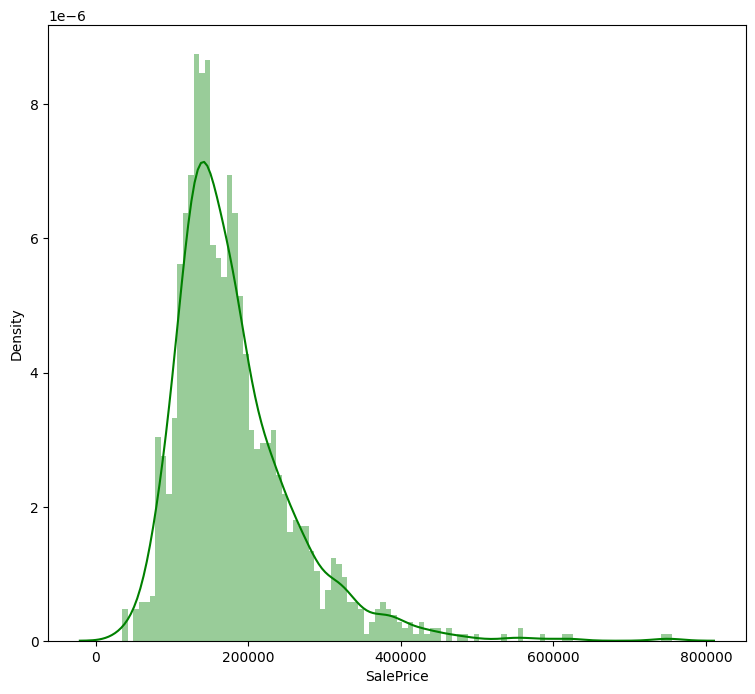

In [139]:
#נבחן את עמודת המחירים- אותה נרצה לנבא
print(train_data['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_data['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [140]:

# שלב 2: הסרת עמודות עם פחות מ-100 ערכים שאינם NaN
train_data = train_data.dropna(thresh=100, axis=1)
test_data = test_data[train_data.columns.drop('SalePrice', errors='ignore')]  # שמירת אותן עמודות גם ב-test data למעט עמודת המחיר


In [141]:
# שלב 3: חישוב קורלציות עם המחיר ומחיקת עמודות מספריות עם קורלציה נמוכה
numerical_features = train_data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = train_data[numerical_features].corr()
price_correlation = correlation_matrix['SalePrice'].abs().sort_values(ascending=False)
threshold = 0.1  # סף לקורלציה נמוכה
high_corr_features = price_correlation[price_correlation > threshold].index

# שמירה על העמודות המספריות עם קורלציה גבוהה והוספת העמודות הקטגוריאליות
categorical_features = train_data.select_dtypes(include=['object']).columns
selected_features = list(high_corr_features) + list(categorical_features)


In [142]:
# הוספת עמודת ה-ID
selected_features = ['Id'] + selected_features + ['SalePrice']
train_data = train_data[selected_features]
selected_features_noprice = [feature for feature in selected_features if feature != 'SalePrice']
test_data = test_data[[feature for feature in selected_features_noprice if feature in test_data.columns]]


In [143]:
# התאמת העמודות ב-test_data לפי train_data
missing_cols = set(selected_features_noprice) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0  # נניח ערך ברירת מחדל

test_data = test_data[selected_features_noprice]


In [144]:
# שלב 4: הסרת ערכים חריגים (Outliers) עבור עמודות מספריות בלבד הקיימות בנתונים
valid_numerical_features = [feature for feature in high_corr_features if feature in train_data.columns]
Q1 = train_data[valid_numerical_features].quantile(0.25)
Q3 = train_data[valid_numerical_features].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = ~((train_data[valid_numerical_features] < (Q1 - 1.5 * IQR)) | (train_data[valid_numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)
train_data = train_data[outlier_condition]

In [145]:
# הסרת עמודות כפולות אם קיימות
train_data = train_data.loc[:,~train_data.columns.duplicated()]


In [146]:
#נבחן שוב את עמודת המחיר- נראה כי הערכים הקיצוניים ירדו וכי יש פחות משתנים הטבלה.
print(train_data['SalePrice'].describe())

count       777.000000
mean     171626.989704
std       54406.192787
min       35311.000000
25%      132500.000000
50%      165000.000000
75%      202500.000000
max      339750.000000
Name: SalePrice, dtype: float64


C:\Users\avoav\AppData\Local\Temp\ipykernel_160956\2535640208.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


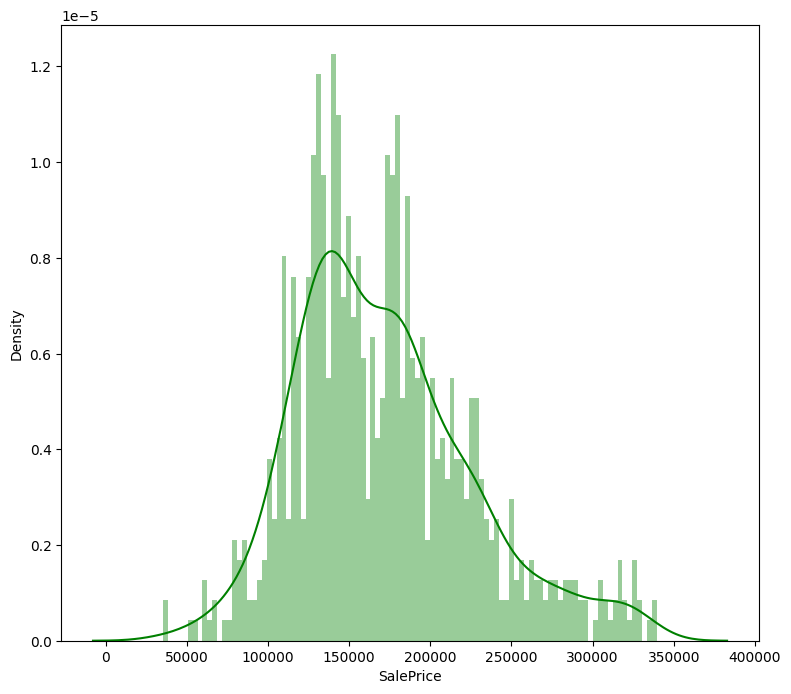

In [155]:
plt.figure(figsize=(9, 8))
sns.distplot(train_data['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [147]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 777 entries, 0 to 1457
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             777 non-null    int64  
 1   SalePrice      777 non-null    int64  
 2   OverallQual    777 non-null    int64  
 3   GrLivArea      777 non-null    int64  
 4   GarageCars     777 non-null    int64  
 5   GarageArea     777 non-null    int64  
 6   TotalBsmtSF    777 non-null    int64  
 7   1stFlrSF       777 non-null    int64  
 8   FullBath       777 non-null    int64  
 9   TotRmsAbvGrd   777 non-null    int64  
 10  YearBuilt      777 non-null    int64  
 11  YearRemodAdd   777 non-null    int64  
 12  GarageYrBlt    747 non-null    float64
 13  MasVnrArea     772 non-null    float64
 14  Fireplaces     777 non-null    int64  
 15  BsmtFinSF1     777 non-null    int64  
 16  LotFrontage    628 non-null    float64
 17  WoodDeckSF     777 non-null    int64  
 18  2ndFlrSF      

In [148]:
# שלב 5: הפרדת משתנים תלויים ובלתי תלויים
X = train_data.drop(['SalePrice'], axis=1)
y = train_data['SalePrice'].values.ravel()  # ודא כי y חד-ממדי


In [150]:
# שלב 6: חלוקה לסט אימון וסט אימות
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [151]:
# הסרת עמודת ה-ID לאחר החלוקה לסטים
X_train = X_train.drop(['Id'], axis=1)
X_valid = X_valid.drop(['Id'], axis=1)
test_data_no_id = test_data.drop(['Id'], axis=1)


In [152]:
# עדכון משתנים מספריים וקטגוריאליים אחרי הסינון
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns


In [153]:

# שלב 7: יצירת Pipelines לטיפול בערכים חסרים וקטגוריאליים ולהוספת TruncatedSVD
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # מילוי ערכים חסרים במספר ממוצע
    ('scaler', StandardScaler()),  # סטנדרטיזציה
    ('transformer', PowerTransformer())  # שינוי התפלגות הנתונים ללוגריתם או תפלגות אחרת
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # מילוי ערכים חסרים בערך הנפוץ ביותר
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # קידוד OneHot לערכים קטגוריאליים
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# הוספת TruncatedSVD לצמצום ממדיות ולאחר מכן MinMaxScaler לנרמול
pipeline_with_svd = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components=50)),  # צמצום למספר רכיבים מתאים
    ('scaler', MinMaxScaler())  # נרמול
])



In [154]:
# שלב 8: עיבוד הנתונים עם TruncatedSVD ו-MinMaxScaler
X_train_processed = pipeline_with_svd.fit_transform(X_train)
X_valid_processed = pipeline_with_svd.transform(X_valid)
X_test_processed = pipeline_with_svd.transform(test_data_no_id)


In [109]:

# פונקציה לכוונון היפר-פרמטרים
def tune_model(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_processed, y_train)
    return grid_search.best_estimator_


In [110]:

# שלב 9: הגדרת המודלים וכוונון היפר-פרמטרים
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": tune_model(DecisionTreeRegressor(), {'max_depth': [5, 10, 20, None]}),
    "SVM": tune_model(SVR(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf']}),
    "AdaBoost": tune_model(AdaBoostRegressor(), {'n_estimators': [50, 100, 200]}),
    "K-Nearest Neighbors": tune_model(KNeighborsRegressor(), {'n_neighbors': [3, 5, 10]}),
    "Random Forest": tune_model(RandomForestRegressor(), {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 20, None]}),
    "Gradient Boosting": tune_model(GradientBoostingRegressor(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]}),
    # "XGBoost": tune_model(xgb.XGBRegressor(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]})
}


In [117]:
# הרצת המודלים והדפסת התוצאות
results = {}
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    predictions = model.predict(X_valid_processed)
    mse = mean_squared_error(y_valid, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_valid, predictions)
    results[name] = {"MSE": mse, "RMSE": rmse, "R2": r2}
    print(f"{name} - MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

Linear Regression - MSE: 413705139.69, RMSE: 20339.74, R2: 0.84
Decision Tree - MSE: 779754712.78, RMSE: 27924.09, R2: 0.70
SVM - MSE: 879887007.31, RMSE: 29662.89, R2: 0.66
AdaBoost - MSE: 463007664.58, RMSE: 21517.61, R2: 0.82
K-Nearest Neighbors - MSE: 798754572.31, RMSE: 28262.25, R2: 0.69
Random Forest - MSE: 442734743.52, RMSE: 21041.26, R2: 0.83
Gradient Boosting - MSE: 384382243.85, RMSE: 19605.67, R2: 0.85


קורלציות עם מחיר הדירה:
SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
Id               0.021917
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2    

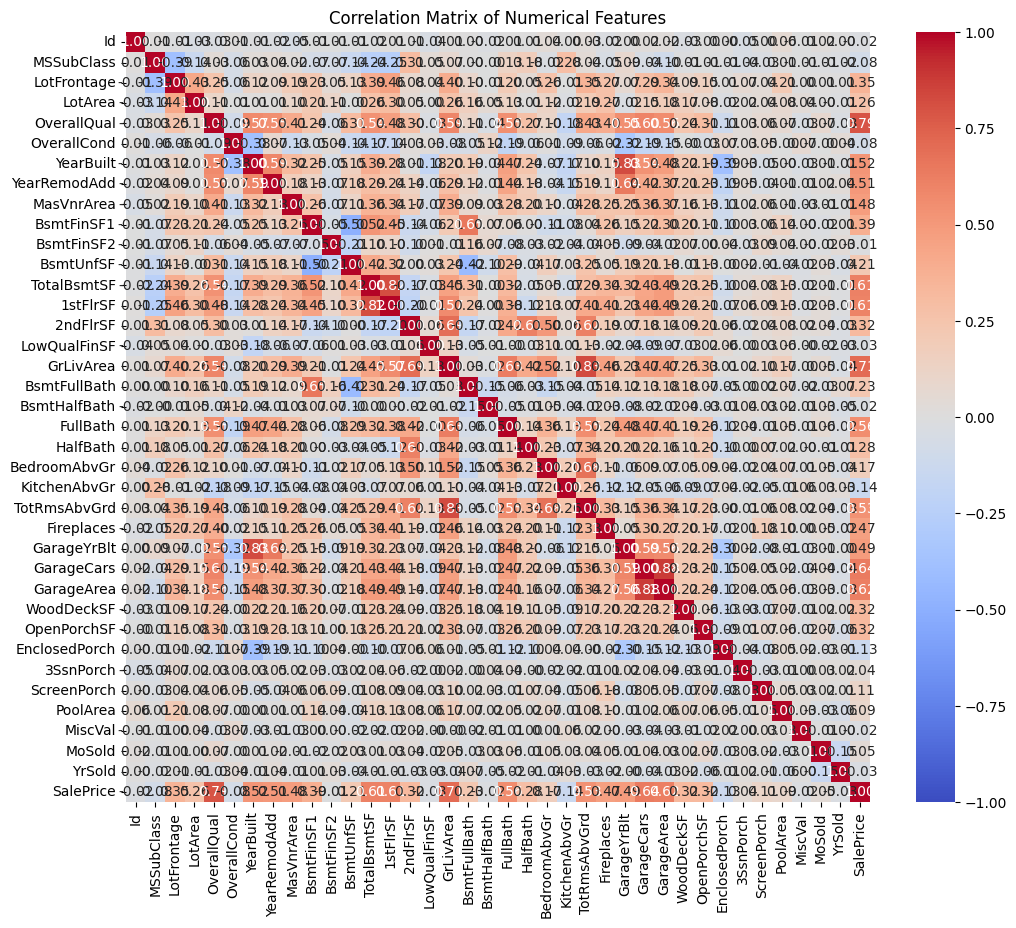

In [112]:
# שימוש ב-ID והכנת הקובץ להגשה
best_model = models["Gradient Boosting"]  # נניח שהמודל הטוב ביותר הוא XGBoost
final_predictions = best_model.predict(X_test_processed)

submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': final_predictions
})

submission.to_csv('submission.csv', index=False)

# הצגת הקורלציות
print("קורלציות עם מחיר הדירה:")
print(price_correlation)

# הצגת מפת חום של הקורלציות
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


קורלציות גבוהות עם מחיר הדירה:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


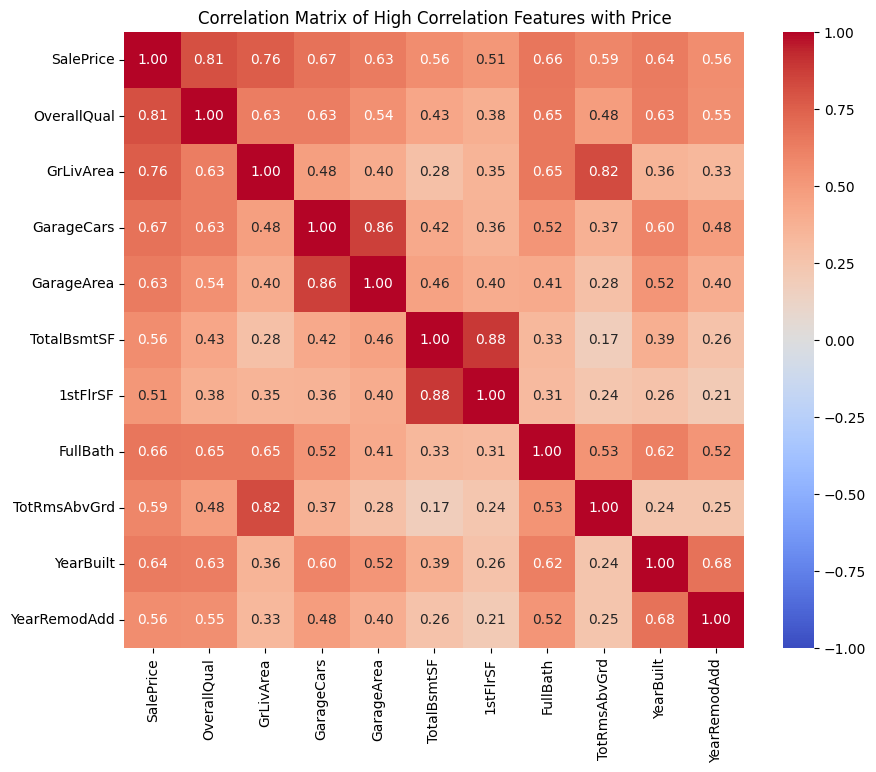

In [156]:
# בחירת עמודת המחיר
price_correlation = correlation_matrix['SalePrice'].sort_values(ascending=False)

# סינון ערכים עם קורלציה גבוהה
threshold = 0.5
high_price_corr = price_correlation[abs(price_correlation) >= threshold]

# הצגת הקורלציות
print("קורלציות גבוהות עם מחיר הדירה:")
print(high_price_corr)

# הצגת מפת חום של קורלציות גבוהות
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[high_price_corr.index].corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of High Correlation Features with Price')
plt.show()